In [1]:
# !pip install -q torch properties

In [3]:
import numpy as np
import torch
from scipy.integrate import odeint

from matches import oscillator
from matches.layers import DenseLayer
from matches.utils import set_kwargs
from matches.data import data_dict_to_torch_data_loader

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.1)
sns.set_style("darkgrid")
%matplotlib inline

print(torch.__version__)

1.0.1.post2


## Equations of the mass-spring system

$$
\frac{d^2x}{dt} = - \frac{\nu}{m} \frac{dx}{dt} - \frac{k}{m}x \\
\frac{d^2x}{dt} = - \nu_{eff}\frac{dx}{dt} - k_{eff}x \\
$$

In [4]:
y0 = 1.0
yprime_0 = 0.0
initial_condition = (1.0, 0.0)

time_end = 35
time = np.linspace(0., time_end, 1000)

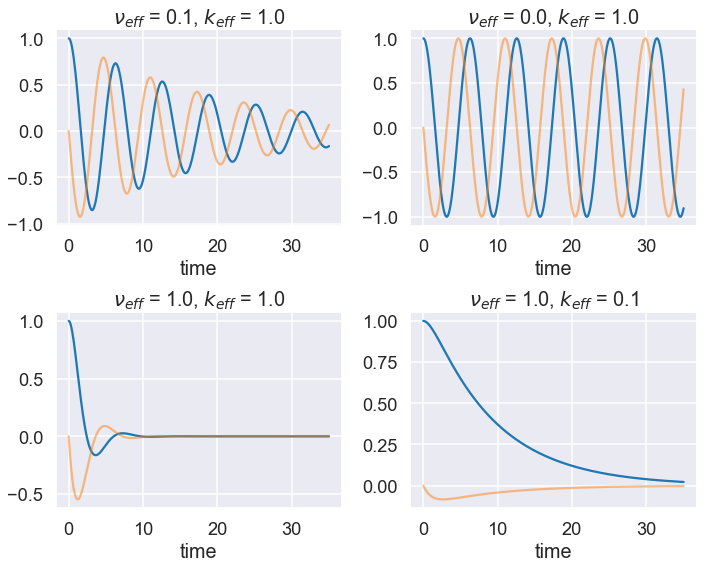

In [5]:
nu_eff = np.r_[0.1, 0.0, 1.0, 1.0]
k_eff = np.r_[1.0, 1.0, 1.0, 0.1]

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.flatten()

for i, a in enumerate(ax):
    out = oscillator.mass_spring(time, nu_eff[i], k_eff[i], initial_condition)
    a.plot(time, out[:, 0], label="y")
    a.plot(time, out[:, 1], label="y'", alpha=0.5)
    
    a.set_title("{} = {}, {} = {}".format("$\\nu_{eff}$", nu_eff[i], "$k_{eff}$", k_eff[i]))
    a.set_xlabel("time")
 
plt.tight_layout()

## Create data set 

In [6]:
nsamples = 2**11  # this number should be small (~1000) when testing
nvalid = 1**11

ntimesteps = 128  # how many time steps to take
time_range = 35  # how far out to simulate in time
times = np.linspace(0, time_range, ntimesteps)

In [7]:
%%time
training_data_dict = oscillator.simulate_data(time=times, nsamples=nsamples)
valid_data_dict = oscillator.simulate_data(time=times, nsamples=nsamples)

CPU times: user 2.15 s, sys: 23.5 ms, total: 2.18 s
Wall time: 2.12 s


Text(0.5, 1.0, "y'")

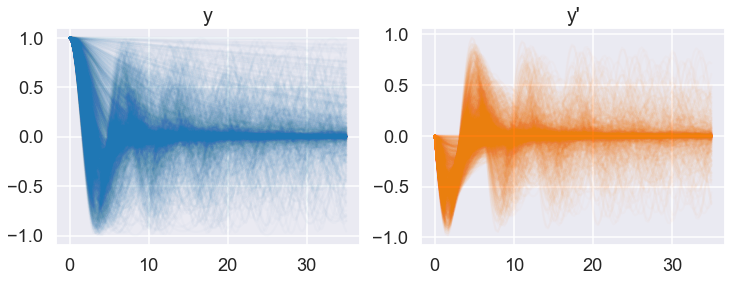

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(times, training_data_dict["y"].T, color="C0", alpha=0.02);
ax[1].plot(times, training_data_dict["y_prime"].T, color="C1", alpha=0.02);

ax[0].set_title("y")
ax[1].set_title("y'")

Text(0.5, 1.0, "y' valid")

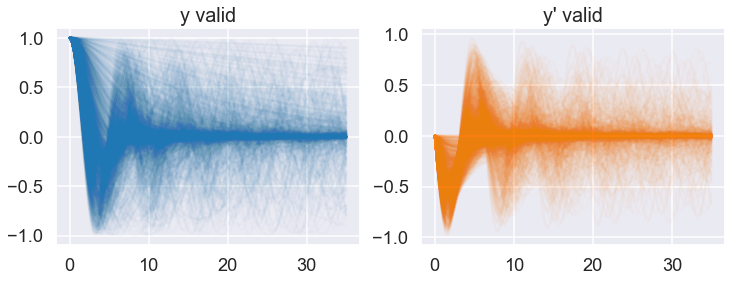

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(times, valid_data_dict["y"].T, color="C0", alpha=0.02);
ax[1].plot(times, training_data_dict["y_prime"].T, color="C1", alpha=0.02);

ax[0].set_title("y valid")
ax[1].set_title("y' valid")

In [10]:
from torch import nn

In [11]:
torch_activations = [
    "threshold", "relu", "hardtanh", "relu6", "elu", "selu", "celu", "leaky_relu",
    "prelu", "rrelu", "glu", "logsigmoid", "hardshrink", "tanhshrink", "softsign",
    "softplus", "softmin", "softmax", "softshrink", "gumbel_softmax", "log_softmax",
    "tanh", "sigmoid"
]
        

class DenseNet(nn.Module):
    
    latent_dim = 2  #: output size of the bottleneck layer 
    layer_dims = [64, 32, 16]  #: list of layer dimensions"
    layer_activation = "relu"  #: activation function for the dense layers
    bottleneck_activation = "tanh"  #: activation function for the bottleneck layer
    output_activation = "tanh"  #: activation function for the final output layer
    batchnorm_ind = 1  #: location in the encoding or decoding for a batchnormalization step
    
    def __init__(self, data_loader=None, **kwargs):
        super().__init__()
        
        self.input_shape = (data_loader.batch_size,)+tuple(data_loader.dataset.tensors[0].shape[1:])
        self.output_shape = (training_dl.batch_size,)+tuple(data_loader.dataset.tensors[1].shape[1:])
        set_kwargs(self, **kwargs)
        
        # encoding / decoding
        input_shapes = [np.prod(self.input_shape)] + self.layer_dims
        output_shapes = [self.latent_dim] + self.layer_dims[::-1]
        encoding = []
        decoding = []
        
        for i in range(len(self.layer_dims)):
            encoding += [DenseLayer(shape=input_shapes[i:i+2], activation=self.layer_activation)]
            decoding += [DenseLayer(shape=output_shapes[i:i+2], activation=self.layer_activation)]
            
            if self.batchnorm_ind is not None:
                if self.batchnorm_ind == i+1:
                    encoding += [nn.BatchNorm1d(input_shapes[i+1])]
                    decoding += [nn.BatchNorm1d(output_shapes[i+1])]
        
        self.encoding = nn.ModuleList(encoding)
        
        # bottleneck
        self.bottleneck = DenseLayer(
            shape=(self.layer_dims[-1], self.latent_dim),
            activation=self.bottleneck_activation
        )
        
        self.decoding = nn.ModuleList(decoding)
        
        # output_layer
        self.output = DenseLayer(
            shape=(output_shapes[-1], np.prod(self.output_shape)),
            activation=self.output_activation
        )
    
    
    def encode(self, x):
        y = x.flatten()
        for enc in self.encoding:
            y = enc(y)
            
        return self.bottleneck(y)
    
    def decode(self, x):
        for dec in self.decoding:
            y = dec(y)

        y = self.output(y)
        
        return(self.output_shape)
        
    def forward(self, x):
        return self.decode(self.encode(x))
        
        

In [12]:
input_keys = ["nu_effective", "k_effective"]
output_keys = ["y"]

training_dl = data_dict_to_torch_data_loader(
    training_data_dict, input_keys, output_keys
)

In [13]:
net = DenseNet(training_dl)
print(net)

DenseNet(
  (encoding): ModuleList(
    (0): DenseLayer(
      (layer): Linear(in_features=2048, out_features=64, bias=True)
    )
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): DenseLayer(
      (layer): Linear(in_features=64, out_features=32, bias=True)
    )
    (3): DenseLayer(
      (layer): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (bottleneck): DenseLayer(
    (layer): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoding): ModuleList(
    (0): DenseLayer(
      (layer): Linear(in_features=2, out_features=16, bias=True)
    )
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): DenseLayer(
      (layer): Linear(in_features=16, out_features=32, bias=True)
    )
    (3): DenseLayer(
      (layer): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (output): DenseLayer(
    (layer): Linear(in_features=64, out_features=131072, bias=True)
  )
)


In [ ]:
lr = 1e-2  # learning rate
epochs = 40  # number of epochs
# bs = 1024  # batch size
    

model = net
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_fct = nn.MSELoss()

def train_epoch(data_loader):
    for i, data 

def train(data_loader):
    for epoch in range(epochs):
        print("\n Epoch {}".format(epoch))
    

# for epoch in range(epochs):
    
#     for i in range(0, )
#     dpred = model(input_data)
#     loss = loss_fct(dpred, input_data)
#     print(f"Epoch {epoch+1}/{epochs}   loss: {loss:1.4e}")
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [17]:
model.

<generator object Module.parameters at 0x7f2eb3bd4d58>

In [18]:
data.shape

(2000, 128, 2)